When examining the nature of your network's arrangement, the concept of *assortativity* is a complicated, albeit deeply-intuitive one. You can think of it as the network analog to a correlation or coincidence score-- it's bounded between `[-1, 1]` and represents how much nodes in the network have self-arranged with other nodes that look like it.

## Data

To dive into this concept, I'll borrow a dataset representing faculty relationships at a university, keyed by the department they work in (`group` for each node).

([Link](http://hal.elte.hu/~nepusz/research/datasets/))

In [1]:
%pylab inline

import networkx as nx

G = nx.read_graphml('data/univ_dataset_TSPE.graphml')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# simple helper function

pos = None

def draw(G, new_pos=False, colors=None):
    global pos
    
    if (pos is None) or new_pos:
        pos = nx.spring_layout(G)
        
    fig, ax = plt.subplots(figsize=(20, 10))
    nx.draw(G, alpha=.5, pos=pos, node_color=colors)

Inexplicably, every time I run it, there's this wild outlier

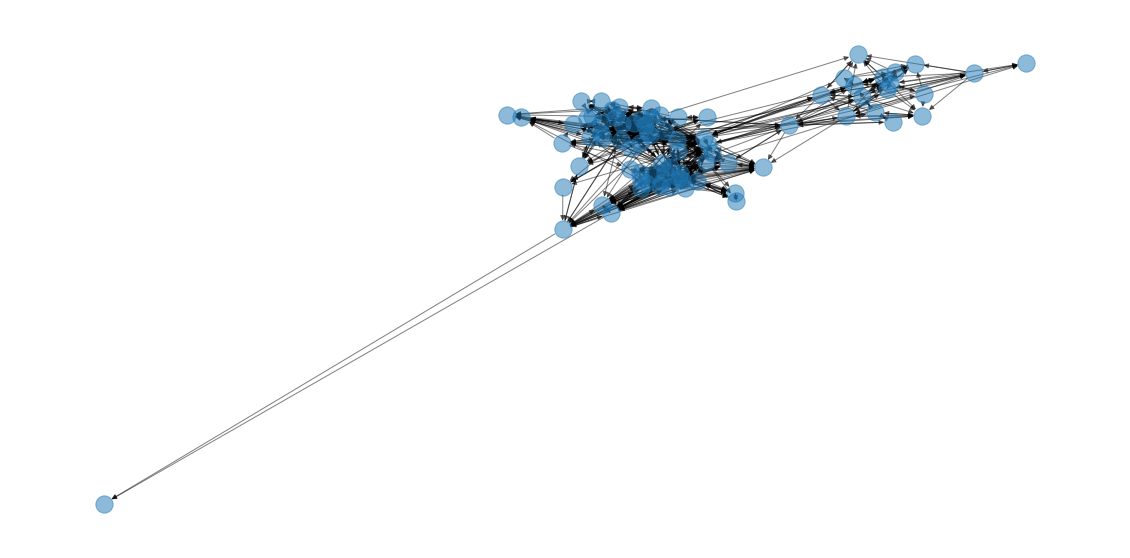

In [3]:
draw(G)

so I'm going to drop it for the sake of visual clarity.

In [4]:
G.remove_node('n10')

Much better!

Now to the matter at hand. How much did this network self-organize by the node attribute `group`?

In [5]:
group_dict = {idx: node['group'] for idx, node in G.nodes(data=True)}

color_dict = {0.0: 'red',
              1.0: 'blue',
              2.0: 'green',
              3.0: 'black'}

colors = [color_dict[group] for group in group_dict.values()]

A fair amount, it seems

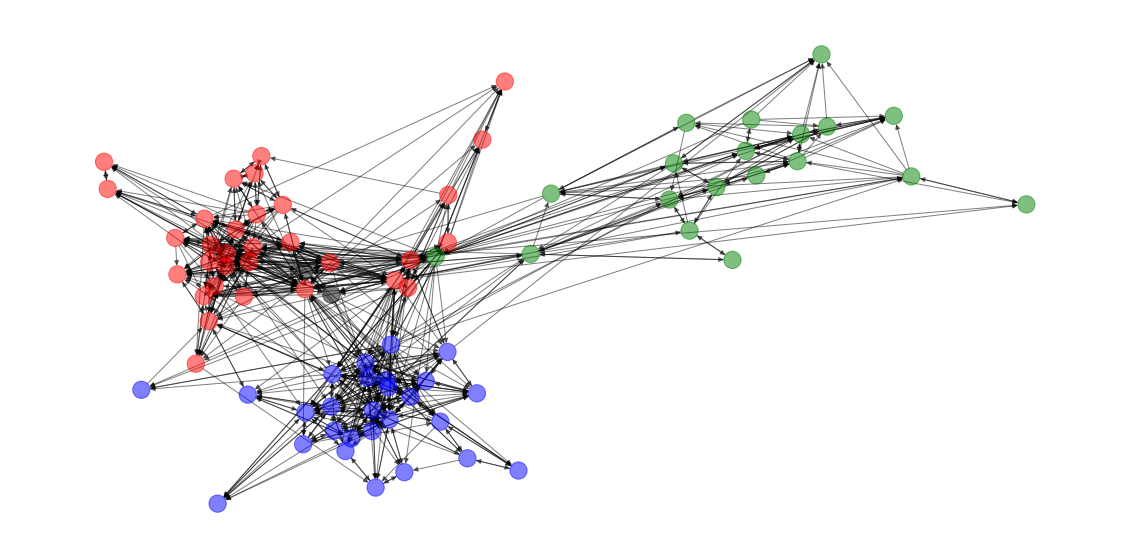

In [6]:
draw(G, new_pos=True, colors=colors)

In fact, the assortativity coefficient is actually quite high.

In [7]:
nx.attribute_assortativity_coefficient(G, 'group')

0.7048747599784635

... but how did we arrive at it?

## Constituent Parts

Before we walk through the underlying `networkx` code, I want to share the key formula from [the seminal paper on the topic.](https://arxiv.org/abs/cond-mat/0209450)

The following equation gives us the assortativity coefficient, `r`. Here, we're only considering the *discrete* case (continuous in a few)-- the paper that introduces the concept starts by encoding a categorical variable to numeric and going from there.

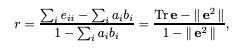

In [8]:
from IPython.display import Image

Image('images/assortativity.png')

Let's break this down a bit, using the table they provided at the beginning

- `r` represents the assortativity coefficient
- `e` is the "fraction of edges in a network that connect a vertex of type `i` to type `j`". This is essentially a co-incidence matrix, normalized by the number of values, therefore the value of `e` sum to 1.

In [9]:
e = np.array([[.258, .016, .035, .013],
              [.012, .157, .058, .019],
              [.013, .023, .306, .035],
              [.005, .007, .024, .016]])

sum(e)

0.9969999999999999

- For a given node, `i`, the `a` and `b` terms are the fraction of that node's in/outbound edges that connect to the various other classes. In an undirected graph, these are equivalent.

In [10]:
a = np.sum(e, axis=1)
b = np.sum(e, axis=0)

display(a)
display(b)

array([0.322, 0.246, 0.377, 0.052])

array([0.288, 0.203, 0.423, 0.083])

- `Tr` is a Linear Algebra operation where you sum the values along the diag. So in the right-hand chunk, summing `e` down the diag means summing the total proportion of edges in the network that map from same-type to same-type nodes.

In [11]:
tr_e = np.trace(e)
tr_e

0.7370000000000001

- The double-bar `e**2` term is a bit dense. Double-bar in this context means "the sum of all elements in the matrix", that's easy enough. Otherwise, you should recognize that squaring the matrix `e` and taking the sum of `a * b` for all values of `i` are literally the same thing-- just consolidates it all into one step.

Stare at this until you believe that.

In [12]:
np.sum(a * b)

0.30646100000000004

In [13]:
e_squared_barbar = np.sum(e @ e)
e_squared_barbar

0.306461

Putting it altogether, we get

In [14]:
(
    (tr_e - e_squared_barbar)
    /
    (1 - e_squared_barbar)
)

0.6207855650511365

which is consistent with the value reported in the paper.

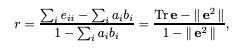

In [15]:
Image('images/assortativity.png')

## In `networkx`

Getting back to it, let's see how this is all stitched together under the hood.

`node_attribute_xy`

In the example above, we *started* with our matrix, `e`-- the proportional coincidence matrix. So before we can really get going, we have to start there.

The `nx.node_attribute_xy()` function is an **awesome** generator that looks at every edge to serve up the `attribute` tuple for each connected pair

In [16]:
xy = list(nx.node_attribute_xy(G, attribute='group'))

list(
    (a, b)
    for (a, b) in xy
    if a != b
)[:10]

[(1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 2.0),
 (1.0, 2.0),
 (1.0, 2.0),
 (1.0, 3.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 3.0)]

`mixing_dict`

Next, we pipe that list of tuples into `nx.mixing_dict()` to get a nested-dict representation of our matrix `e`

In [17]:
nx.mixing_dict(xy)

{2.0: {2.0: 96, 0.0: 21, 1.0: 13, 3.0: 2},
 0.0: {0.0: 315, 1.0: 41, 3.0: 14, 2.0: 13},
 1.0: {0.0: 24, 1.0: 250, 2.0: 6, 3.0: 2},
 3.0: {0.0: 11, 3.0: 2, 2.0: 2, 1.0: 3}}

Alternatively, we could just use the following function that combines the last two steps

In [18]:
mixing_dict = nx.attribute_mixing_dict(G, 'group')

`mixing_matrix`

Finally, we build our `e` matrix from the mixing dict, calculated above.

In [19]:
manual = np.zeros((4, 4))

for i, row in enumerate(sorted(mixing_dict)):
    for j, col in enumerate(sorted(mixing_dict[row])):
        manual[i][j] = mixing_dict[row][col]
        
manual

array([[315.,  41.,  13.,  14.],
       [ 24., 250.,   6.,   2.],
       [ 21.,  13.,  96.,   2.],
       [ 11.,   3.,   2.,   2.]])

Of course, there's a simple helper method that does this for us.

We can either get this as raw counts

In [20]:
mix_mat_raw = nx.attribute_mixing_matrix(G, 'group', normalized=False)
mix_mat_raw

array([[315.,  41.,  13.,  14.],
       [ 24., 250.,   6.,   2.],
       [ 21.,  13.,  96.,   2.],
       [ 11.,   3.,   2.,   2.]])

Or normalize the whole thing to sum to 1 (which is a necessary characteristic of `e`)

In [21]:
mix_mat_raw / mix_mat_raw.sum()

array([[0.38650307, 0.05030675, 0.01595092, 0.01717791],
       [0.02944785, 0.30674847, 0.00736196, 0.00245399],
       [0.02576687, 0.01595092, 0.11779141, 0.00245399],
       [0.01349693, 0.00368098, 0.00245399, 0.00245399]])

In [22]:
mix_mat = nx.attribute_mixing_matrix(G, 'group')
mix_mat

array([[0.38650307, 0.05030675, 0.01595092, 0.01717791],
       [0.02944785, 0.30674847, 0.00736196, 0.00245399],
       [0.02576687, 0.01595092, 0.11779141, 0.00245399],
       [0.01349693, 0.00368098, 0.00245399, 0.00245399]])

Finally, we plug-and-chug as above and see a *considerable* assortativity by `group`-- which mirrors our visual intuition nicely

In [23]:
tr_e = mix_mat.trace()

e_squared_barbar = np.sum(mix_mat @ mix_mat)

(
    (tr_e - e_squared_barbar)
    /
    (1 - e_squared_barbar)
)

0.7048747599784635

In the likely event that you don't want to do this all by hand, there's absolutely a function that handles this all in a flash.

In [24]:
nx.attribute_assortativity_coefficient(G, 'group')

0.7048747599784635

## Continuous Analog

Although the actual math is different, it's possible to run the same function to apply the same general method on arbitrary continuous data.

To demonstrate, let's build a trivial variable, based on the `id` value that a node gets instantiated with.

In [25]:
list((
    data
    for    node, data
    in     G.nodes(data=True)
))[:5]

[{'group': 2.0, 'id': 'n0'},
 {'group': 0.0, 'id': 'n1'},
 {'group': 2.0, 'id': 'n2'},
 {'group': 2.0, 'id': 'n3'},
 {'group': 1.0, 'id': 'n4'}]

Literally, just stripping off the leading `n` and casting as an `int`

In [26]:
node_ids = {node: int(data['id'][1:])
             for node, data 
             in G.nodes(data=True)}

nx.set_node_attributes(G, values=node_ids, name='node_id')

list((
    data
    for    node, data
    in     G.nodes(data=True)
))[:5]

[{'group': 2.0, 'id': 'n0', 'node_id': 0},
 {'group': 0.0, 'id': 'n1', 'node_id': 1},
 {'group': 2.0, 'id': 'n2', 'node_id': 2},
 {'group': 2.0, 'id': 'n3', 'node_id': 3},
 {'group': 1.0, 'id': 'n4', 'node_id': 4}]

And so running the equation over our `node_id` values, we get a value that's very close to `0`, suggesting that there is NO assortativity, with respect to `node_id`.

Put another way, this suggests that the nodes were introduced to the network in a random fashion-- as we showed above there is clearly assortativity by `group`. So if nodes were added one *group* at a time, it follows that there would be a high degree of intra-group correlation. Summing that over the network, we'd expect to see something positive but small, probably in the `.2-.4` range.

In [27]:
nx.attribute_assortativity_coefficient(G, 'node_id')

-0.015185949939552698

### Degree Assortativity

Finally, we can peek at one of the more popular measures in this space and see how *degree* assortative our data is.

Do high-degree nodes disproportionately seek out other high degree nodes? Think about it: how often do celebrities marry total nobodies, vs other "nodes" with comparable star power?

To start, we'll tack on a raw `degree` attribute and calculate the way we know how.

In [28]:
degrees = {node: degree
             for node, degree 
             in G.degree}

nx.set_node_attributes(G, values=degrees, name='degree')

list((
    data
    for    node, data
    in     G.nodes(data=True)
))[:5]

[{'group': 2.0, 'id': 'n0', 'node_id': 0, 'degree': 15},
 {'group': 0.0, 'id': 'n1', 'node_id': 1, 'degree': 36},
 {'group': 2.0, 'id': 'n2', 'node_id': 2, 'degree': 8},
 {'group': 2.0, 'id': 'n3', 'node_id': 3, 'degree': 18},
 {'group': 1.0, 'id': 'n4', 'node_id': 4, 'degree': 38}]

Looks pretty random to me.

In [29]:
nx.attribute_assortativity_coefficient(G, 'degree')

-0.0015635016182241753

Checking against the native function, I was surprised by how much I was off

In [30]:
nx.degree_assortativity_coefficient(G)

0.0356095440281665

Until I realized that this particular network is a *directed* graph

In [31]:
type(G)

networkx.classes.digraph.DiGraph

And that there's an additional wrinkle you have to keep straight when rewriting the equation for `r` to consider in-degree vs out-degree separately. I'll omit the particulars for now, but if it turns out that this is crucial to understand, I'll come back and elaborate.

Casting `G` as an undirected graph for a sec, this is MUCH closer to what we did more manually :)

In [32]:
nx.degree_assortativity_coefficient(nx.Graph(G))

-0.004034673332927811